##### Why did you select each of these datasets?

Well for one I am huge sports fan, so thats the reason for looking at Player Injuries.  Secondly, the reason for looking into Diabetes is that my mother had diabetes (and passed from complications) so there is some interest in preventions/treatments for this disease. 

##### List 5 specific questions/ideas about each of your datasets (take a look at the variables and see what you might uncover by asking certain questions of the dataset.)

NFL Injury Dataset:
    1. Is there a relationship between playing time and injury
    2. Is there a relationship between weather (temperature and dry vs precipitation) and injury
    3. Is there a relationship between the types of injurys and the types of plays
    4. Is there a relationship between the types of injurys and the position of the player
    5. Can you predict conditions for high probability of injury and from this develop a few ideas to help in preventing injury for NFL players.
    
Diabetes Dataset:
    1. What factors could be linked to higher risk of diabetes
    2. Can you predict if someone if more susceptible to diabetes or not
    3. Is there any relationship between number of pregnancies and increased or decreased glucose levels
    4. What role does BMI play in overall health
    5. Can you use this information, maybe combined with additional resources (like research papers) to increase education for not only patients but also providers.  
    

##### Lastly, what do you hope to get out of this capstone project and what kinds of analyses are you hoping to get more practice with based on the datasets you have selected?

Honestly I'd like to get more hands on experience dealing with a real world problem.  BAS 230 was actually really great with this.  honestly the more I started to dig into the Diabetes dataset the more interested I become in analyzing that data.  I would love to look at decision trees and maybe other classification models to help guide the conversation around factors that could lead to diabetes and support it in a statistical manner.  Also would love to run some nueral network models on whatever project I decide to go with. 

##### Begin exploring your data visually (create scatter plots, histograms, descriptive statistics) or create a data dictionary/copy+paste a data dictionary provided to you.

### NFL Injury Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as patches
sns.set_style("whitegrid")

#create path variable to be used for reading data
path = '/home/dummy_user/badams_testing/'

In [68]:
plays = pd.read_csv(path + 'PlayList.csv')
injury = pd.read_csv(path + 'InjuryRecord.csv')
players = pd.read_csv(path + 'PlayerTrackData.csv')

#source: https://www.kaggle.com/c/nfl-playing-surface-analytics

#### Play List Data

Lets first take a look at the play list file contains the details for the 267,005 player-plays that make up the dataset. Each play is indexed by PlayerKey, GameID, and PlayKey fields. Details about the game and play include the player’s assigned roster position, stadium type, field type, weather, play type, position for the play, and position group.

In [7]:
plays.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


In [8]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267005 entries, 0 to 267004
Data columns (total 14 columns):
PlayerKey         267005 non-null int64
GameID            267005 non-null object
PlayKey           267005 non-null object
RosterPosition    267005 non-null object
PlayerDay         267005 non-null int64
PlayerGame        267005 non-null int64
StadiumType       250095 non-null object
FieldType         267005 non-null object
Temperature       267005 non-null int64
Weather           248314 non-null object
PlayType          266638 non-null object
PlayerGamePlay    267005 non-null int64
Position          267005 non-null object
PositionGroup     267005 non-null object
dtypes: int64(5), object(9)
memory usage: 28.5+ MB


In [11]:
# Number of unique plays 
plays['PlayKey'].nunique()

267005

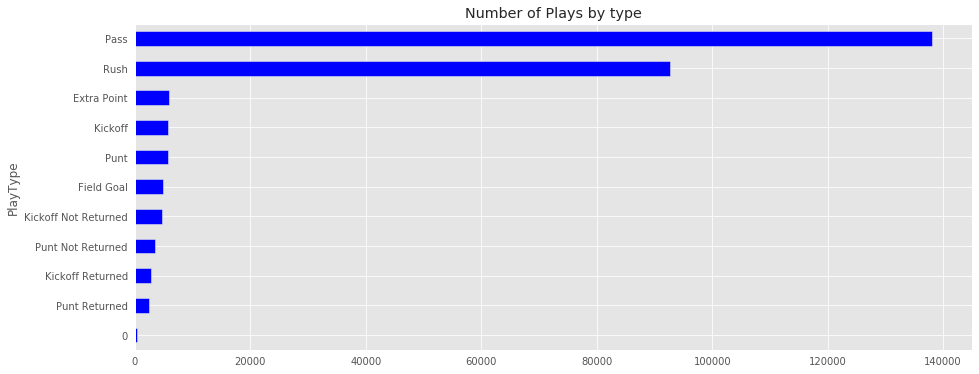

In [31]:
plays[['PlayKey','PlayType']].drop_duplicates() \
    .groupby('PlayType').count()['PlayKey'] \
    .sort_values() \
    .plot(kind='barh',
         figsize=(15, 6),
          color='blue',
         title='Number of Plays by type')
plt.show()

So we can see from the above, nothing shocking here, Pass plays are the most common play type, followed by rush then plays in the kicking game (or special teams plays). 

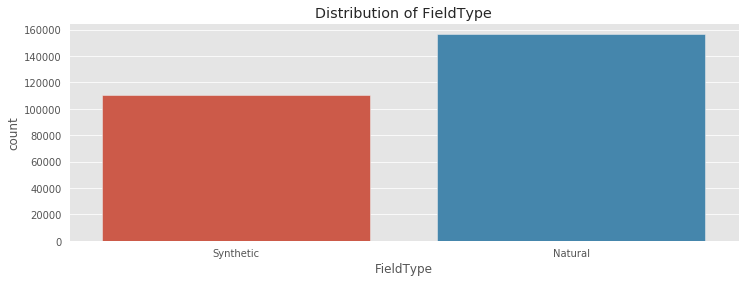

In [25]:
plt.figure(figsize=(12,4))
ax = sns.countplot(plays['FieldType'])
plt.title('Distribution of FieldType');

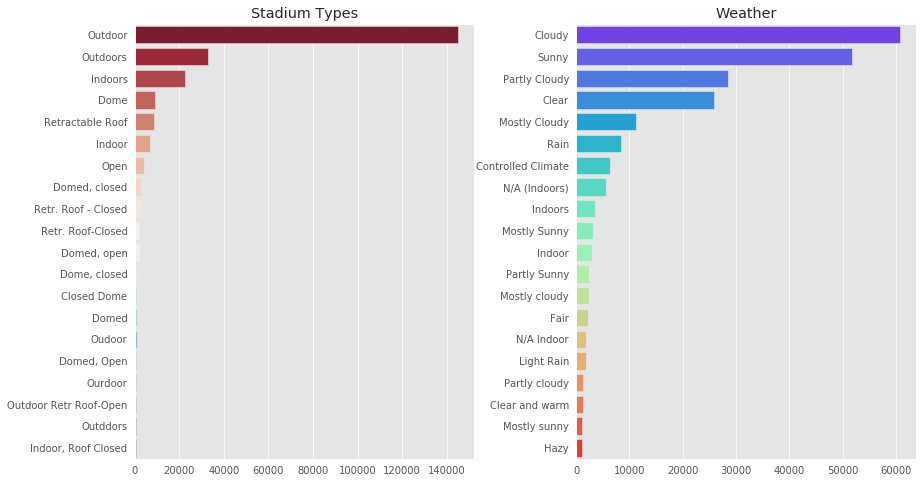

In [33]:
f,ax = plt.subplots(1,2, figsize=(14,8))
ax1,ax2, = ax.flatten()
cnt = plays['StadiumType'].value_counts()[:20].to_frame()

sns.barplot(cnt['StadiumType'], cnt.index, palette = 'RdBu', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Stadium Types')

cnt = plays['Weather'].value_counts()[:20].to_frame()

sns.barplot(cnt['Weather'], cnt.index, palette = 'rainbow', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Weather')
plt.subplots_adjust(wspace=0.3)

So we can see from the above there is some data transformation we can do in order to clean up the stadium types and weather a bit.  So what we can do is group some of these categories into bigger buckets. 

In [35]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']
    
    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']
    
    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']
    
    snow = ['Heavy lake effect snow']
    
    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']
        
    if row.Weather in cloudy:
        return 'Cloudy'
    
    if row.Weather in indoor:
        return 'Indoor'
    
    if row.Weather in clear:
        return 'Clear'
    
    if row.Weather in rainy:
        return 'Rain'
    
    if row.Weather in snow:
        return 'Snow'
      
    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan
    
    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def clean_play_df(plays):
    plays_cleaned = plays.copy()
    
    # clean StadiumType
    plays_cleaned['StadiumType'] = plays_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    plays_cleaned['StadiumType'] = plays_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    plays_cleaned['StadiumType'] = plays_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    plays_cleaned['StadiumType'] = plays_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    plays_cleaned['StadiumType'] = plays_cleaned['StadiumType'].str.replace('Open', 'Outdoor')
    plays_cleaned['StadiumType'] = plays_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)
    
    plays_cleaned['Weather'] = plays_cleaned.apply(lambda row: clean_weather(row), axis=1)
        
    return plays_cleaned

In [36]:
plays_cleaned = clean_play_df(plays).copy()

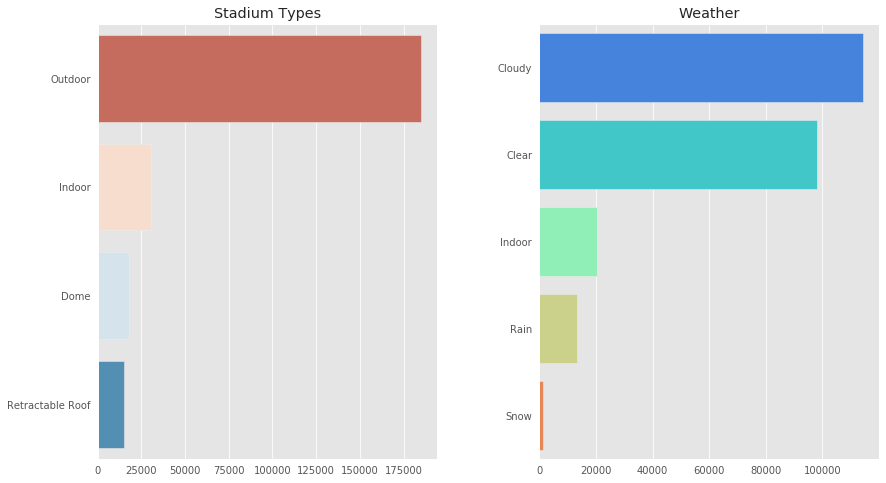

In [37]:
#Now lets take a look back at the Stadium and Weather data
f,ax = plt.subplots(1,2, figsize=(14,8))
ax1,ax2, = ax.flatten()
cnt = plays_cleaned['StadiumType'].value_counts()[:20].to_frame()

sns.barplot(cnt['StadiumType'], cnt.index, palette = 'RdBu', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Stadium Types')

cnt = plays_cleaned['Weather'].value_counts()[:20].to_frame()

sns.barplot(cnt['Weather'], cnt.index, palette = 'rainbow', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Weather')
plt.subplots_adjust(wspace=0.3)

This looks much better and will be easier for us to later on. 

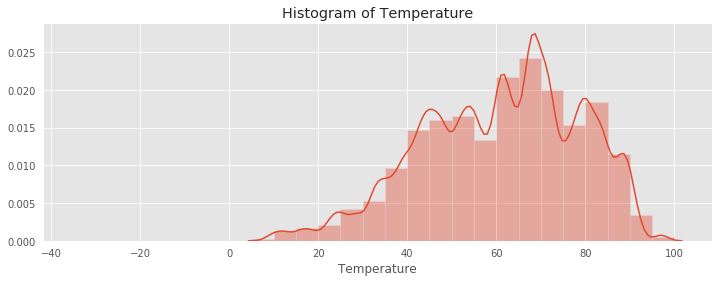

In [47]:
plt.figure(figsize=(12,4))
ax = sns.distplot(plays_cleaned['Temperature'], bins = 20, hist_kws={"range": [0,100]}, kde_kws={"clip":(0,100)})
plt.title('Histogram of Temperature');

So I only displayed the historgram here for values between 0 and 100.  There are some values that are showing as -999 degrees, which would be impressive but impossible to play a game in.  However from this data we can see it is slightly left skewed, and you may could argue it is bimodal.  Bimodal wouldnt be too far off, as it makes sense there would be a peak for winter games and a peak for late summer/fall games, as the NFL season is split between those seasons.  

The Boxplot below we can see that there is a major outlier at the -999 position which we could most probably remove from our dataset as just bad data.  For now I will keep it, but if I were to be building models here I would probably create a copy and remove the outlier data for temperature and run my models on both datasets (one with all temp data and one with having removed the outlier temp data) to see how it impacted my model performance. 

Text(0.5, 1.0, 'Boxplot of Temperature')

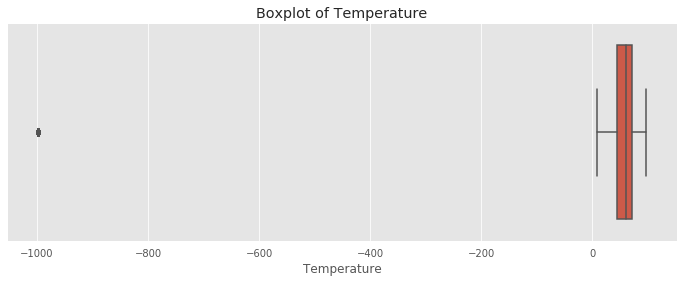

In [55]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(plays_cleaned['Temperature'])
plt.title('Boxplot of Temperature')

### Injury Data

Lets take a quick look at the Injury dataset here.  The injury record file in .csv format contains information on 105 lower-limb injuries that occurred during regular season games over the two seasons. Injuries can be linked to specific records in a player history using the PlayerKey, GameID, and PlayKey fields.

In [59]:
injury.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


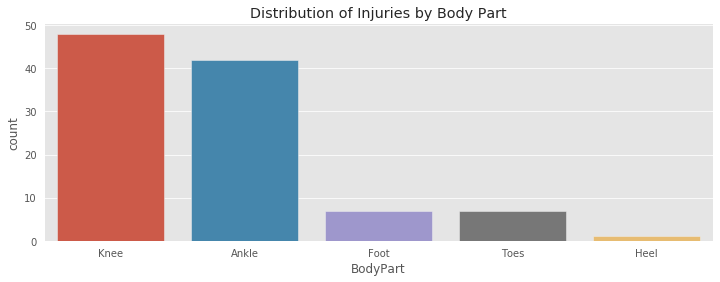

In [60]:
plt.figure(figsize=(12,4))
ax = sns.countplot(injury['BodyPart'])
plt.title('Distribution of Injuries by Body Part');

No surprises here, knees and ankles have the heavy edge in NFL injuries

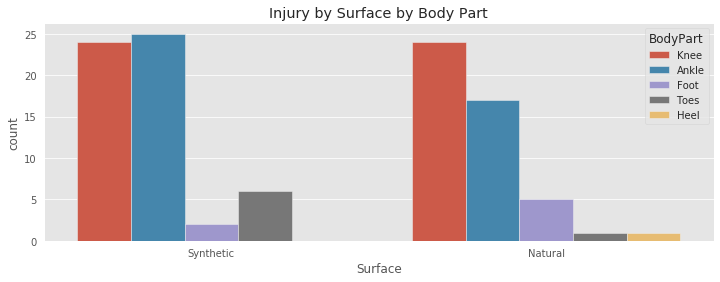

In [63]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x = "Surface", hue = "BodyPart", data = injury)
plt.title('Injury by Surface by Body Part');

This is pretty cool to look at.  Here we have the Injuries by surface and which body part was injured.  If anyone has ever played on synthetic surfaces, it shouldnt come as a big surprise that ankle and toe injuries are way more prevelant than on natural surfaces.  This is of course without considering any other factors. 

### Player Track Data: 

Lets have a look at the player track dataset. This dataset contains Player level data that describes the location, orientation, speed, and direction of each player during a play recorded at 10 Hz (i.e. 10 observations recorded per second).

In [70]:
players.head()

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


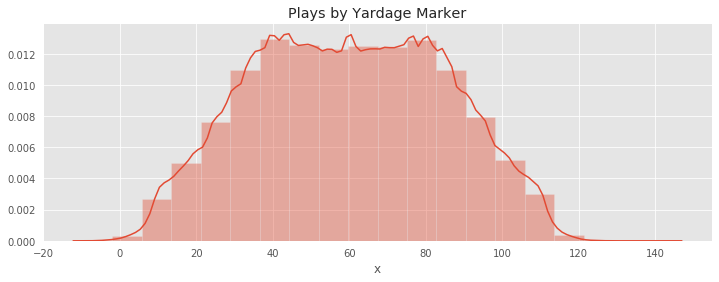

In [74]:
plt.figure(figsize=(12,4))
ax = sns.distplot(players['x'], bins = 20)
plt.title('Plays by Yardage Marker');

This is pretty interesting to see.  The majority of plays take place between the 28 (or so) and the opponents 20 roughly. My assumption here is that the extra 20 yards is to account for enzones (10 yards on both sides fo the field). 

Now the last bit of exploration I'll do for this dataset (since I have another whole project dataset to look into) is to Match up the Plays data with the injury data and look at some of the information we can derive from that.  

In [77]:
injury_plays = injury.merge(plays_cleaned)

In [78]:
injury_plays.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,Linebacker,29,4,Indoor,Synthetic,84,Cloudy,Punt,32,OLB,LB
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,Linebacker,50,7,Outdoor,Natural,76,Cloudy,Punt,26,OLB,LB
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,Safety,1,1,Outdoor,Synthetic,63,Clear,Pass,70,SS,DB
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,Linebacker,15,3,Outdoor,Natural,80,Cloudy,Punt,30,LB,LB
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,Wide Receiver,32,5,Retractable Roof,Synthetic,89,Cloudy,Kickoff,69,WR,WR


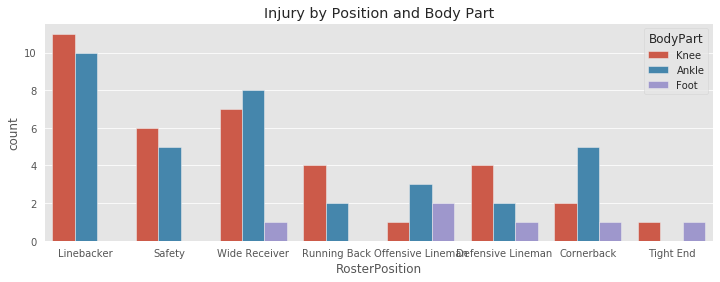

In [80]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x = "RosterPosition", hue = "BodyPart", data = injury_plays)
plt.title('Injury by Position and Body Part');

Looks like Linebacker and Wide Reciever get the most injured.  

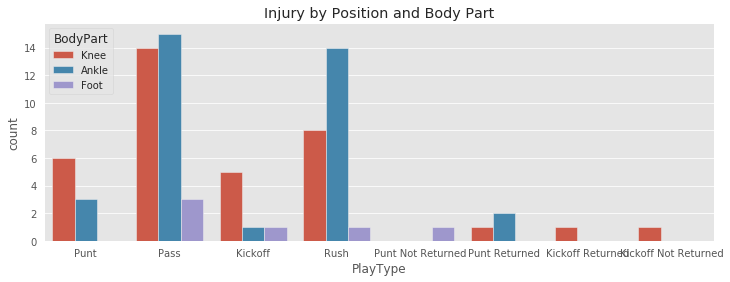

In [81]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x = "PlayType", hue = "BodyPart", data = injury_plays)
plt.title('Injury by Position and Body Part');

Rush plays having the second most ankle injuries doesnt surprise me.  It is interesting to see that pass plays lead by a strong amount in injuries overall and specifically in knee injuries.  In some sense it makes sense, but knowing the wear and tear so publisized for running backs one would think they would have more knee injuries.  We also dont know the severity here either.  

## Diabetes Dataset

In [82]:
diabetes = pd.read_csv(path + 'diabetes.csv')

#source: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [83]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##### Data Dictionary from Source

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

 - Pregnancies: Number of times pregnant
 - Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
 - BloodPressure: Diastolic blood pressure (mm Hg)
 - SkinThickness: Triceps skin fold thickness (mm)
 - Insulin: 2-Hour serum insulin (mu U/ml)
 - BMI: Body mass index (weight in kg/(height in m)^2)
 - DiabetesPedigreeFunction: Diabetes pedigree function
 - Age: Age (years)
 - Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0


In [84]:
#lets just take a look at some basic information for this dataset
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [85]:
#lets take a look at some describtive stats for our dataset
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb704865208>,
      dtype=object)

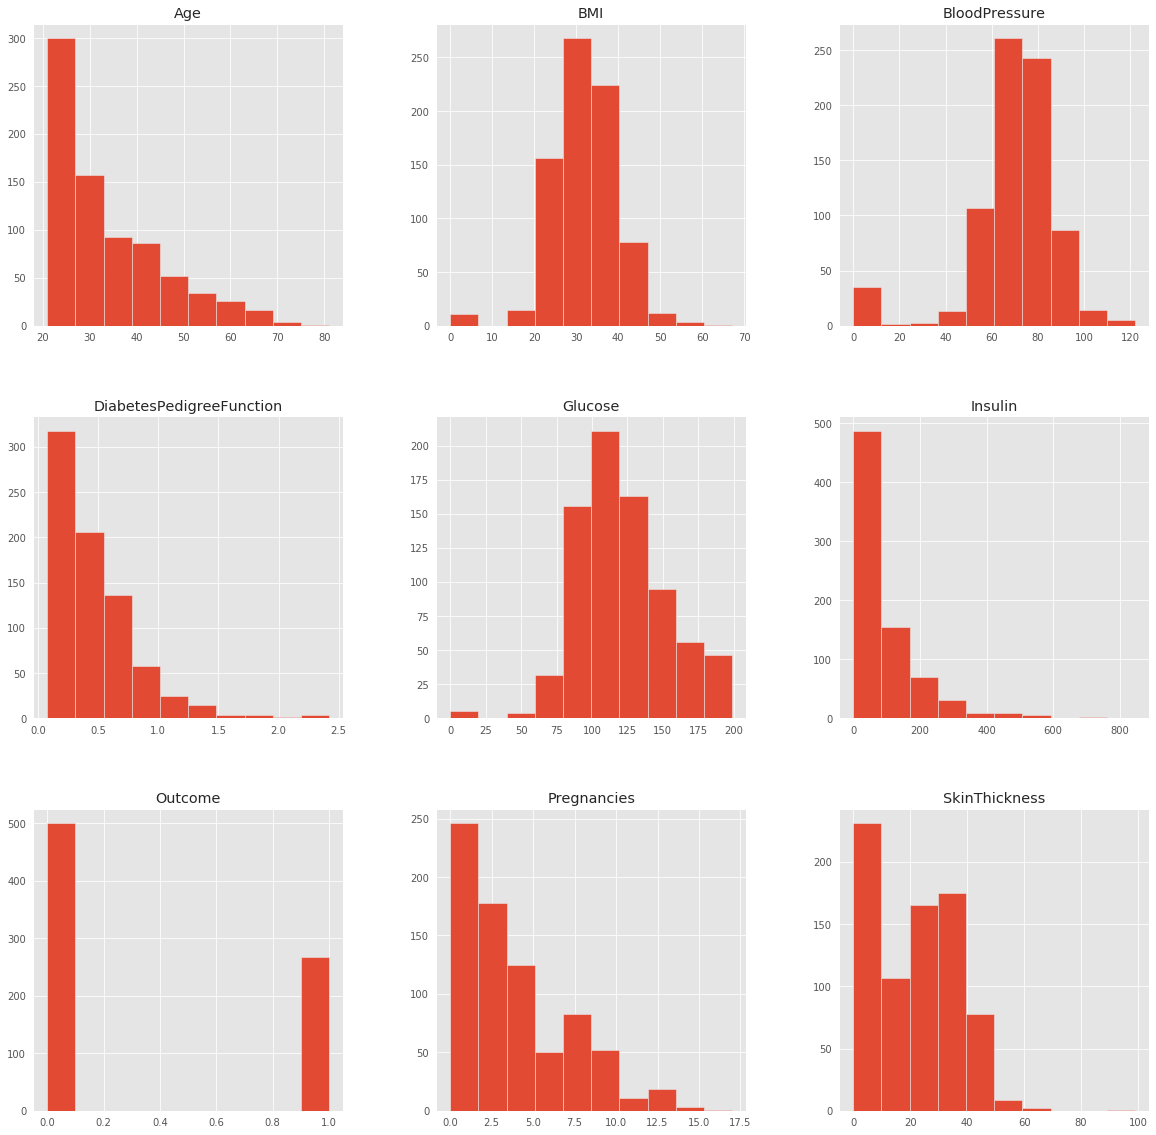

In [86]:
#lets take a look at the distribution of data for all our variables in this datatset
diabetes.hist(figsize = (20,20))

So one thing to note, obviously our outcome data has no skewness.  The majority of our data is right skewed (or positive skewed).  Glucose is appraching normal distribution, as is BMI and Blood Pressure.  One could argue they are slgithly left skewed.  

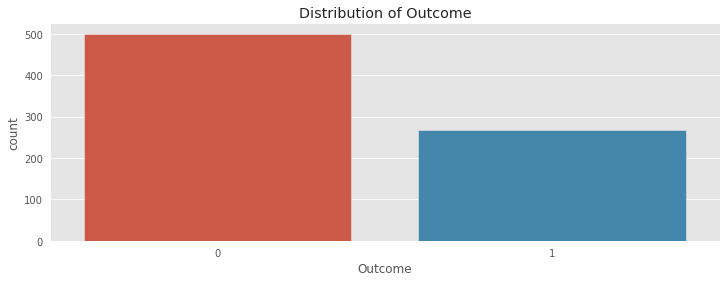

In [88]:
#lets take a closer look at our factor variable 'Outcome'
plt.figure(figsize=(12,4))
ax = sns.countplot(diabetes['Outcome'])
plt.title('Distribution of Outcome');

So those who were not diagnosed with diabetes is almost double that of those who have been diagnosed with diabetes.  

/home/centos/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/centos/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


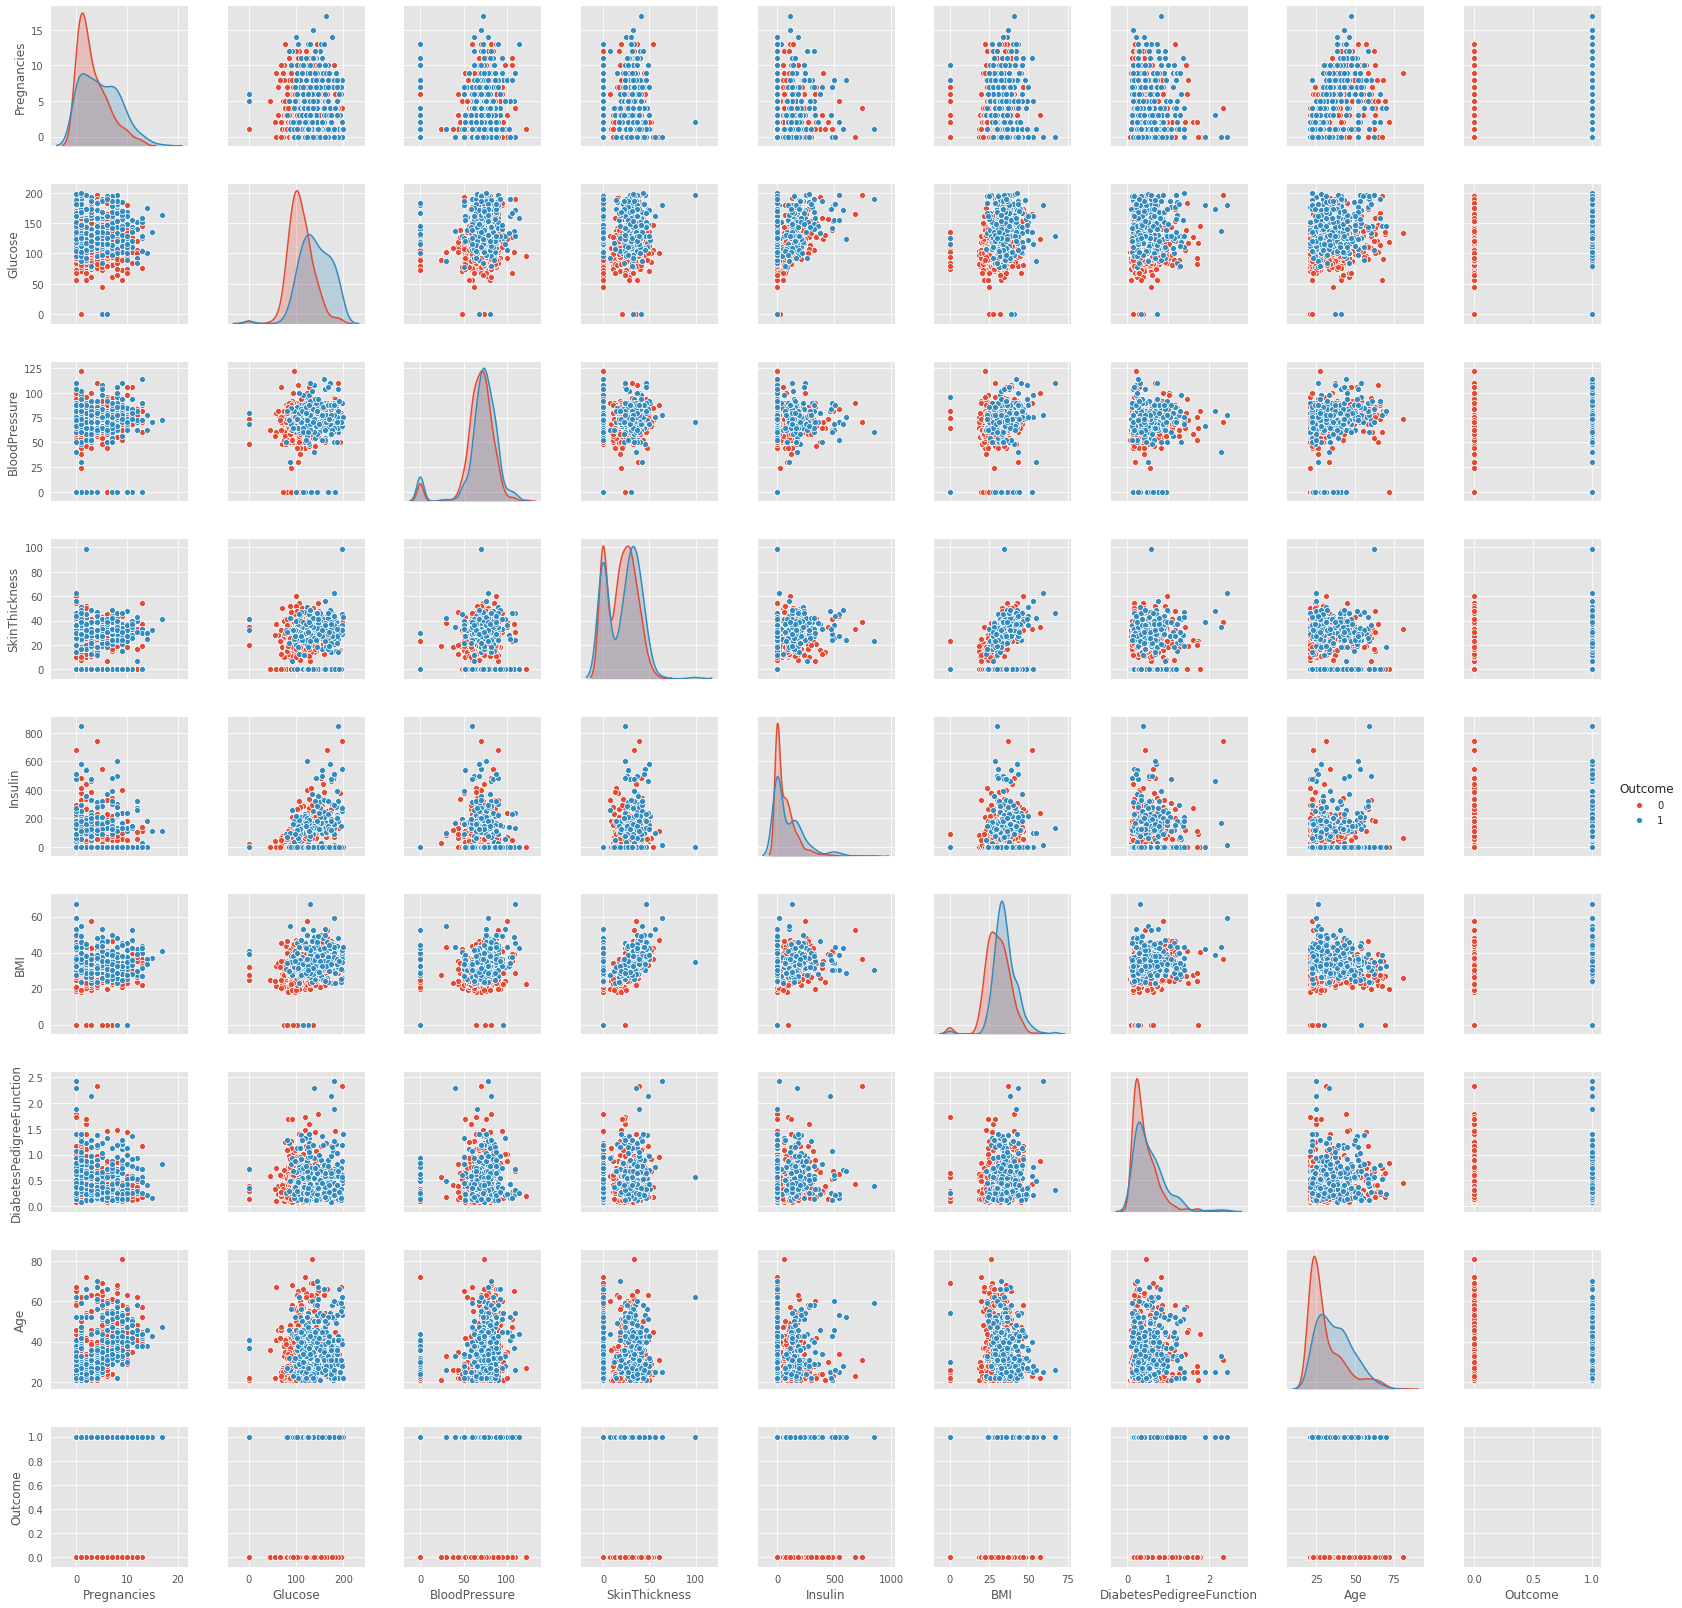

In [89]:
#Lets run a pair plot with out data.
sns.pairplot(diabetes, hue = "Outcome")

So a couple simple observations from this without diving too heavlily.  Those who have diabetes have high levels of glocuse, and in fact when you look at each other variable for glucose that is true across the board. There are some really interesting relationships between these variables, none of them surprising but its neat to see with data. 

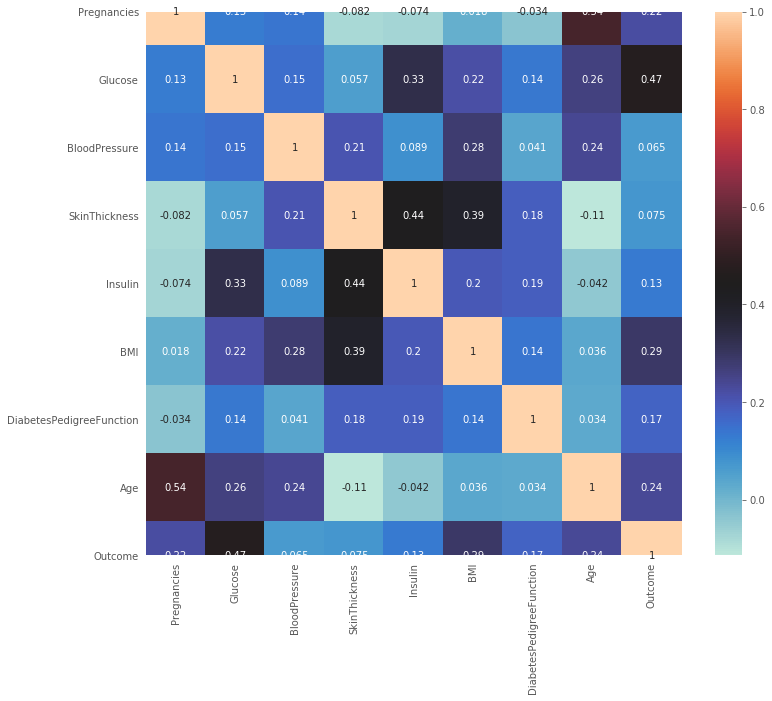

In [97]:
plt.figure(figsize=(12,10))
sns.heatmap(diabetes.corr(), annot = True, cmap = 'icefire')

Some very interesting information here.  Notice the correlation between Age and Pregnancies is over 50.  What is also interesting to me is the relationship between skin thickness and insulin and BMI (BMI isnt that surprising).  I know the correlations are over 70 but still.  Also take a look at the outcome correlations.  Almost three factors have correlation values close to 25 (BMI, Age and Pregnancies), Glucose is nearly 50 (which isnt surprising really but nice to see the data support some assumptions).  

In [101]:
#I want to create Age Groups for some additonal Analysis
def age_buckets(x):
    if x < 30: 
        return '18-29' 
    elif x < 40: 
        return '30-39' 
    elif x < 50: 
        return '40-49' 
    elif x < 60: 
        return '50-59' 
    elif x < 70: 
        return '60-69' 
    elif x >=70: 
        return '70+' 
    else:
        return 'other'
    
diabetes['AgeGroup'] = diabetes.Age.apply(age_buckets)

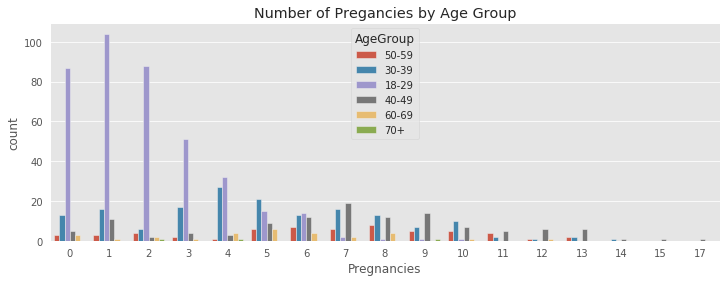

In [103]:
#Lets check out the number of pregnancies by Age Group.  
plt.figure(figsize=(12,4))
ax = sns.countplot(x = "Pregnancies", hue = "AgeGroup", data = diabetes)
plt.title('Number of Pregancies by Age Group');

I think what stands out here is that for those who were pregnancy 7 and more times, the Age Group 40-49 stands out to me.  

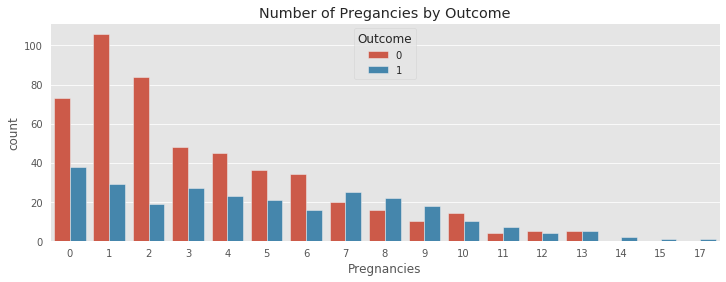

In [105]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x = "Pregnancies", hue = "Outcome", data = diabetes)
plt.title('Number of Pregancies by Outcome');

Interesting to see as someone who has more pregnancies they look to be more likely to have diabetes.  

In [107]:
#lets create a new column to group the BMI scores

#I want to create Age Groups for some additonal Analysis
def BMI_buckets(x):
    if x < 18.5: 
        return 'Underweight' 
    elif x <= 24.9: 
        return 'Normal Weight' 
    elif x <= 29.9: 
        return 'Overweight'
    elif x > 30:
        return 'Obese'
    else:
        return 'other'
    
diabetes['BMIGroup'] = diabetes.BMI.apply(BMI_buckets)

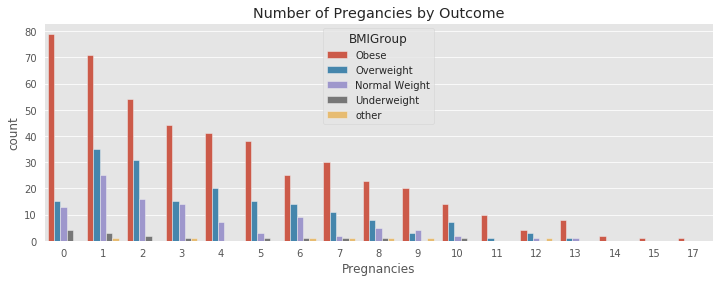

In [108]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x = "Pregnancies", hue = "BMIGroup", data = diabetes)
plt.title('Number of Pregancies by Outcome');

So this shows the lakc of evolution in the BMI calculation (it doesnt take into any other factors other than age and weight). what is interesting here though is check out those who are not pregnant account for the majority of those Obese.  

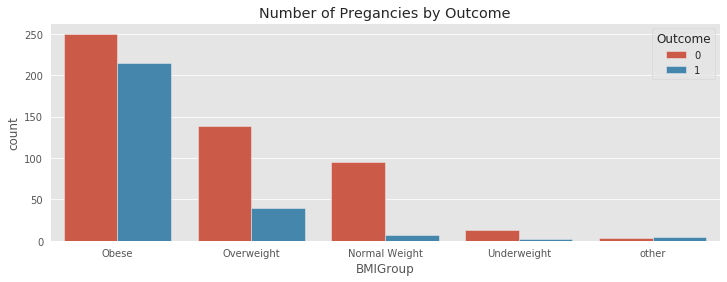

In [109]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x = "BMIGroup", hue = "Outcome", data = diabetes)
plt.title('Number of Pregancies by Outcome');

This does seem to support the notion that the BMI calc may may be a bad measure for indicating if someone is more susceptible to diabetes.  Also notive that those who are diabetic drops off drastically fro Obese to Overweight and then to Normal.  